<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-an-imbalanced,-2D-dataset" data-toc-modified-id="Create-an-imbalanced,-2D-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create an imbalanced, 2D dataset</a></span></li><li><span><a href="#Intrisic-balancing" data-toc-modified-id="Intrisic-balancing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Intrisic balancing</a></span></li><li><span><a href="#Simple-re-sampling" data-toc-modified-id="Simple-re-sampling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple re-sampling</a></span></li><li><span><a href="#SMOTE" data-toc-modified-id="SMOTE-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SMOTE</a></span><ul class="toc-item"><li><span><a href="#Manual-Implementation" data-toc-modified-id="Manual-Implementation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Manual Implementation</a></span></li><li><span><a href="#Using-imblearn" data-toc-modified-id="Using-imblearn-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Using imblearn</a></span></li></ul></li><li><span><a href="#SMOTEENN" data-toc-modified-id="SMOTEENN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>SMOTEENN</a></span></li><li><span><a href="#ADASYN" data-toc-modified-id="ADASYN-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ADASYN</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></div>

In [189]:
import numpy as np
import sklearn
from sklearn.datasets import make_blobs
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -t -m -h -v --iversions

numpy 1.17.2
json  2.0.9
11:34:28 

CPython 3.7.4
IPython 7.8.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-128-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
host name  : ski-lab


References:
* [Wikipedia](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)
* [imblearn](https://github.com/scikit-learn-contrib/imbalanced-learn) python package
* [smote_variants](https://github.com/analyticalmindsltd/smote_variants) python mpackage
* [Lemaître, G. Nogueira, F. Aridas, Ch.K. (2017) Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning, Journal of Machine Learning Research, vol. 18, no. 17, 2017, pp. 1-5.](http://www.jmlr.org/papers/volume18/16-365/16-365.pdf)
* [Chawla, Nitesh V.; Herrera, Francisco; Garcia, Salvador; Fernandez, Alberto (2018-04-20). "SMOTE for Learning from Imbalanced Data: Progress and Challenges, Marking the 15-year Anniversary". Journal of Artificial Intelligence Research. 61: 863–905. doi:10.1613/jair.1.11192. ISSN 1076-9757.](https://doi.org/10.1613%2Fjair.1.11192)
    

Notes

1. Re-balancing methods, whether by intrinsically penalizing misclassification or by resampling, generally have hyperparameters and should be incorported into pipelines that are optimized using k-fold CV.
2. Scaling/standardizing the data **BEFORE** and **AFTER** synthetic data generation is usually best practice, but is not explicitly illustrated below.
3. See the discussion accompanying this notebook for more details, and also the [ml_utils](https://github.com/mahynski/ml_utils/blob/main/sklearn/imbalanced.py) package for some examples.

# Create an imbalanced, 2D dataset

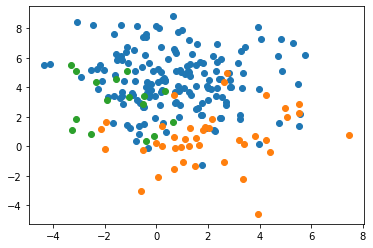

In [78]:
# Generate a random, balanced set
X, Y = sklearn.datasets.make_blobs(n_samples=500, 
                                   n_features=2, 
                                   centers=None, 
                                   cluster_std=2,  
                                   shuffle=True, 
                                   random_state=0)

# Imbalance the set
np.random.seed(0)

scale_down = [1.0, 0.25, 0.1]
X_imb = np.zeros((0,2))
y_imb = []
for i,class_ in enumerate(sorted(np.unique(Y))):
    mask = Y == class_
    limit = int(np.sum(mask)*scale_down[i])
    x_, y_ = X[mask][:limit], Y[mask][:limit]
    
    X_imb = np.concatenate((X_imb, x_))
    y_imb = np.concatenate((y_imb, y_))
    
# Visualize the dataset
for class_ in sorted(np.unique(y_imb)):
    mask = y_imb == class_
    plt.plot(X_imb[mask,0], X_imb[mask,1], 'o')

In [84]:
# From "Python Machine Learning: 2nd Ed." by Raschka and Mirjalili
# https://github.com/PacktPublishing/Python-Machine-Learning-Second-Edition/blob/master/Chapter02/ch02.py
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
        


# Intrisic balancing

Some models like logistic regression and decision trees can weight the error associated with a mistake according to the (inverse) frequency of observing that class.  In this example, the green (minority) class is nearly always incorrectly predicted as being red if balancing is not employed.

In [118]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

def compare(X, y):
    for class_weight in [None, 'balanced']:
        log_reg = Pipeline(steps=[
            ('scaler', StandardScaler(with_mean=True, with_std=True)),
            ('model', LR(penalty='none', random_state=0, 
                         class_weight=class_weight
                        )
            )
        ])

        log_reg.fit(X, y)

        plt.figure()
        plot_decision_regions(X, y, log_reg)
        plt.title("Intrinsically Imbalanced" if not class_weight else "Intrinsically Balanced")
        
        print(classification_report(y, log_reg.predict(X)))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       167
         1.0       0.72      0.68      0.70        41
         2.0       0.50      0.19      0.27        16

    accuracy                           0.83       224
   macro avg       0.70      0.60      0.62       224
weighted avg       0.82      0.83      0.82       224

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81       167
         1.0       0.62      0.83      0.71        41
         2.0       0.24      0.69      0.36        16

    accuracy                           0.73       224
   macro avg       0.60      0.74      0.63       224
weighted avg       0.84      0.73      0.76       224



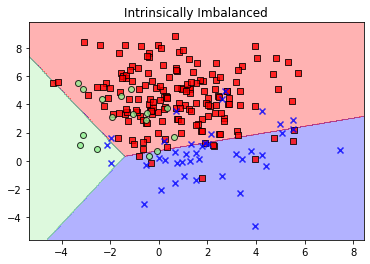

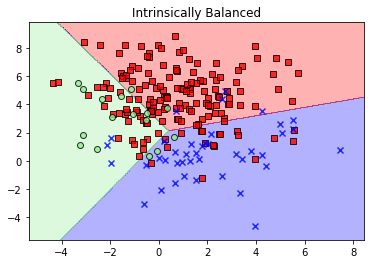

In [119]:
compare(X_imb, y_imb)

# Simple re-sampling

We could also perform "random resampling" akin to bootstrapping, where we randomly choose points from one or more minority classes to repeat in the dataset.

In [122]:
from sklearn.utils import resample

# Let's just resample the minority class - in principle, you can do this to all class not the majority
Xr, yr = resample(X_imb[y_imb==2], # Resample X with y == 2
                  y_imb[y_imb==2], 
                  replace=True, # Sample with replacement
                  n_samples=np.sum(y_imb==0) - np.sum(y_imb==2), # Choose the number of samples to match the majority class
                  random_state=0,
                 )
X_bal = np.concatenate((X_imb, Xr))
y_bal = np.concatenate((y_imb, yr))

              precision    recall  f1-score   support

         0.0       0.78      0.75      0.76       167
         1.0       0.77      0.66      0.71        41
         2.0       0.78      0.84      0.81       167

    accuracy                           0.78       375
   macro avg       0.78      0.75      0.76       375
weighted avg       0.78      0.78      0.78       375

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77       167
         1.0       0.44      0.83      0.57        41
         2.0       0.78      0.75      0.77       167

    accuracy                           0.74       375
   macro avg       0.69      0.76      0.70       375
weighted avg       0.78      0.74      0.75       375



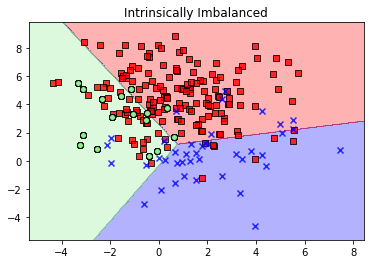

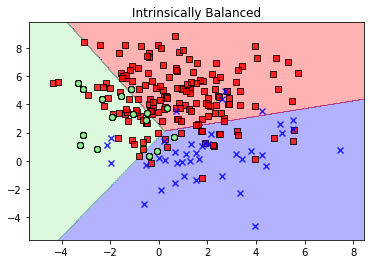

In [123]:
compare(X_bal, y_bal)

Now the decision boundary between the red and green classes doesn't change when the intrinsic class weighting is used.  Resampling by repeating the estimates multiple times is (statistically) the same as the intrinsic weighting approach, though with resampling the exact weight on each point will vary by the exact number of times that point was chosen to be repeated.  The boundaries with the blue, however, does because this class (class 1) is now the minority class.

# SMOTE

SMOTE works by taking pairs of points from the minority class (determined by k neearest neighbors) and interpolating between them to create a synthetic datapoint.  The image below from the [imblearn](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn) documentation illustrates this concept:

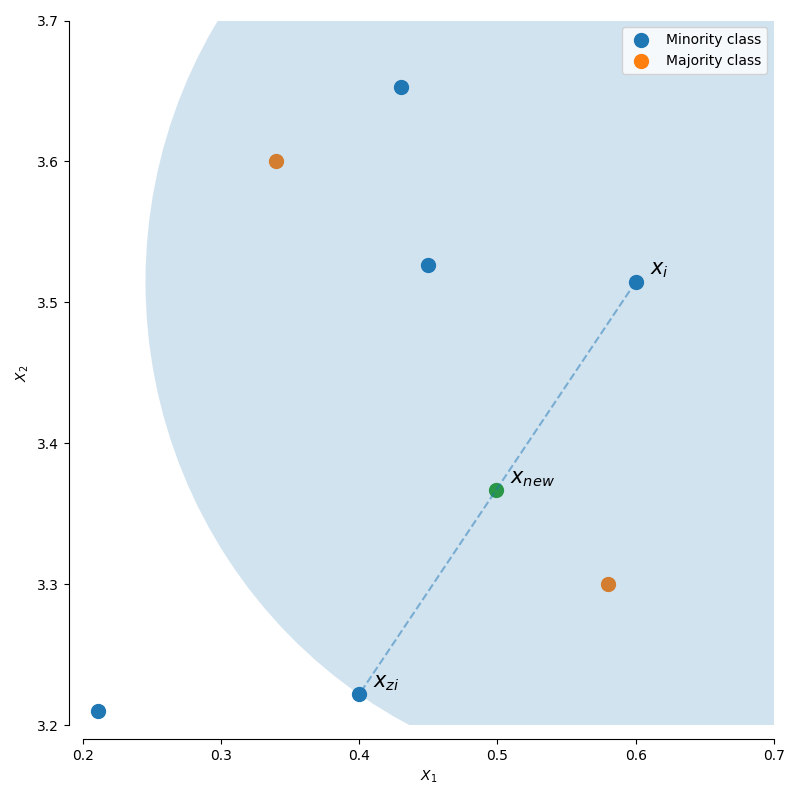

In [190]:
Image(filename='imblearn_generation.png', width=500)

## Manual Implementation

In [179]:
from sklearn.neighbors import NearestNeighbors

def my_smote(X, y, k=5, seed=0):
    """In this version, we resample all classes except the majority one."""
    np.random.seed(seed)
    
    # What is the majority class?
    majority_class = sorted(zip(*np.unique(y, return_counts=True)), key=lambda x:x[1], reverse=True)[0][0]
    n_majority = np.sum(y == majority_class)
    
    X_balanced = np.zeros((0, X.shape[1]))
    y_balanced = np.zeros((0,))
    for class_ in sorted(np.unique(y)):
        mask = y == class_
        if class_ != majority_class:
            # Fit nearest neighbor model
            k_nearest = NearestNeighbors(
                n_neighbors=k, # Find k nearest neighbors
                p=2 # Euclidean distance
            )
            k_nearest.fit(X[mask])
        
            # Copy what we already have
            X_up = X[mask].copy().tolist()
            
            # Generate new points to make up the difference
            num_to_add = n_majority - np.sum(mask) # How many points do we need to add?
            for i in range(num_to_add):
                # 1. Select a random point
                idx = random.randint(0, np.sum(mask)-1)
                start = X[mask][idx]
                nebrs_dist, nebrs_idx = k_nearest.kneighbors([start])
                
                # 2. Select a random neighbor
                idx = random.randint(0, len(nebrs_idx[0])-1)
                end = X[mask][nebrs_idx[0][idx]]
                                           
                # 3. Select random point along vector between the two
                X_up.append(np.random.random()*(end - start) + start)
            
            y_up = np.array([class_]*n_majority)
            X_up = np.array(X_up)
        else:
            # Do nothing to majority class
            y_up = y[mask]
            X_up = X[mask]
            
        X_balanced = np.concatenate((X_balanced, X_up))
        y_balanced = np.concatenate((y_balanced, y_up))
            
    return X_balanced, y_balanced

In [181]:
X_balanced, y_balanced = my_smote(X_imb, y_imb, k=5, seed=0)

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75       167
         1.0       0.77      0.86      0.81       167
         2.0       0.76      0.77      0.76       167

    accuracy                           0.78       501
   macro avg       0.78      0.78      0.78       501
weighted avg       0.78      0.78      0.78       501

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75       167
         1.0       0.77      0.86      0.81       167
         2.0       0.76      0.77      0.76       167

    accuracy                           0.78       501
   macro avg       0.78      0.78      0.78       501
weighted avg       0.78      0.78      0.78       501



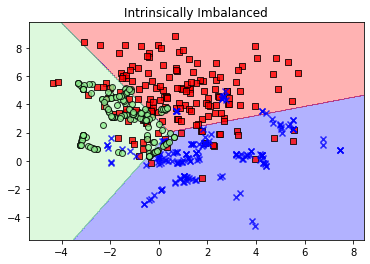

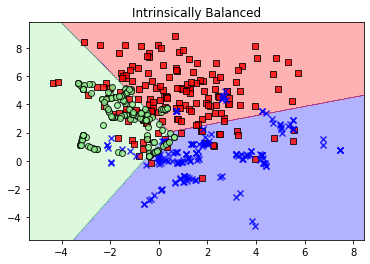

In [182]:
compare(X_balanced, y_balanced) # Intrinsically balancing does nothing because all classes already balanced

Note how the points above "string-like" clusters - this is because of how SMOTE generates synthetic data.

## Using imblearn

In [185]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(
    random_state=0,
    k_neighbors=5,
    sampling_strategy='not majority',
)

X_balanced, y_balanced = smote.fit_resample(X_imb, y_imb)

/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72       167
         1.0       0.78      0.84      0.81       167
         2.0       0.72      0.73      0.72       167

    accuracy                           0.75       501
   macro avg       0.75      0.75      0.75       501
weighted avg       0.75      0.75      0.75       501

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72       167
         1.0       0.78      0.84      0.81       167
         2.0       0.72      0.73      0.72       167

    accuracy                           0.75       501
   macro avg       0.75      0.75      0.75       501
weighted avg       0.75      0.75      0.75       501



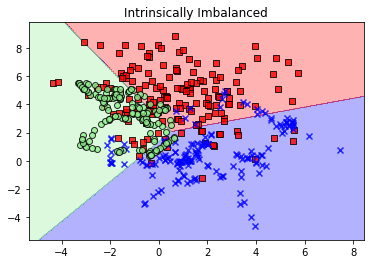

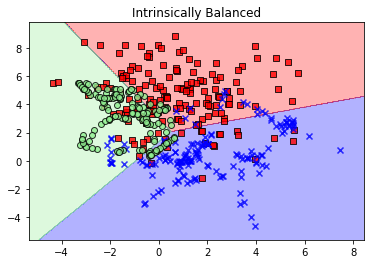

In [186]:
compare(X_balanced, y_balanced)

# SMOTEENN

The problem with SMOTE is that it can choose to draw a connection between inliers and (marginal) outliers.  This noise should optimally be removed somehow.  There are 2 main methods implemented in imblearn which are using Tomek's links and edited nearest neighbors. See the [imblearn documentation](https://imbalanced-learn.org/stable/combine.html) for more examples and discussion.  This combination of under and over sampling is generally optimal.

According to [imblearn's documentation](https://imbalanced-learn.org/stable/under_sampling.html):

> "`EditedNearestNeighbours` applies a nearest-neighbors algorithm and “edit” the dataset by removing samples which do not agree “enough” with their neighboorhood. For each sample in the class to be under-sampled, the nearest-neighbours are computed and if the selection criterion is not fulfilled, the sample is removed. Two selection criteria are currently available: (i) the majority (i.e., kind_sel='mode') or (ii) all (i.e., kind_sel='all') the nearest-neighbors have to belong to the same class than the sample inspected to keep it in the dataset:"

**Note that this means that, unlike vanilla SMOTE, all classes do not have exactly the same number of observations.**

In [193]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours as ENN

sm = SMOTEENN(
    sampling_strategy='not majority',
    random_state=0,
    smote=SMOTE(
        random_state=0,
        k_neighbors=5,
        sampling_strategy='not majority',
    ),
    enn=ENN(
        sampling_strategy='not majority',
        n_neighbors=5,
        kind_sel='mode',
    ),
)

X_balanced, y_balanced = sm.fit_resample(X_imb, y_imb)

/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  war

In [194]:
np.unique(y_balanced, return_counts=True)

(array([0., 1., 2.]), array([167, 147, 156]))

              precision    recall  f1-score   support

         0.0       0.84      0.72      0.78       167
         1.0       0.80      0.90      0.85       147
         2.0       0.74      0.76      0.75       156

    accuracy                           0.79       470
   macro avg       0.80      0.80      0.79       470
weighted avg       0.80      0.79      0.79       470

              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78       167
         1.0       0.80      0.91      0.85       147
         2.0       0.74      0.76      0.75       156

    accuracy                           0.80       470
   macro avg       0.80      0.80      0.80       470
weighted avg       0.80      0.80      0.79       470



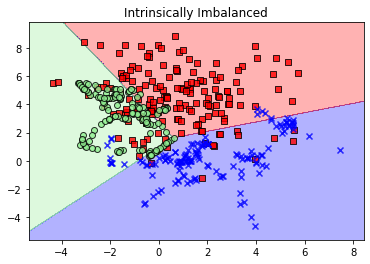

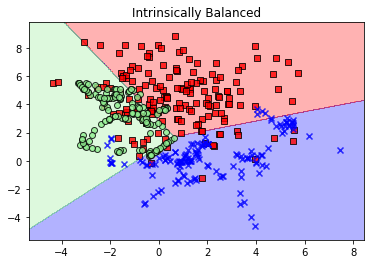

In [195]:
compare(X_balanced, y_balanced) # Slight differences because classes are not perfectly balanced

Compariatively, the datasets are less overlapped now, though performances improve by 5-10% relative to the un-edited version.

# ADASYN

This is a closely related technique, which differs only slightly from SMOTE.  From the [imblearn documentation](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn):

> "While the RandomOverSampler is over-sampling by duplicating some of the original samples of the minority class, SMOTE and ADASYN generate new samples in by interpolation. However, the samples used to interpolate/generate new synthetic samples differ. In fact, ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. Therefore, the decision function found during training will be different among the algorithms."

**Importantly, this means that ADASYN can end up focusing on outliers which is a suboptimal solution.  SMOTE can result in connections between inliers and outliers which is why it is often combined with things like edited nearest neighbors (and also has many variants to combat this).**

# Pipeline

Because resampling outputs both X and y, it is slightly incompatible with sklearn's workflow using pipelines which requires X to be the output after .fit() and .transform() methods, for example.  The imblearn package, however, provides a wrapper that let's you get this pipeline functionality back; you just have to use the imblearn pipeline not sklearn's.

In [204]:
import ml_utils
import imblearn
from ml_utils.sklearn.imbalanced import ScaledSMOTEENN
# from ml_utils.sklearn.feature_selection import PipeBorutaSHAP
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# This pipeline first does balanced, then scaling, then fits the model.
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("smote", ScaledSMOTEENN(random_state=1)),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    # ("boruta", PipeBorutaSHAP(column_names=chosen)), # Can add BorutaSHAP if interested
    ("log_reg", LR(penalty='none', 
                   random_state=0, 
                   class_weight=None
                  )
    )
])

param_grid = {
    'smote__k_enn':[3, 5, 7, 10],
    'smote__k_smote':[3, 5, 7, 10],
    'smote__kind_sel_enn':['all', 'mode'],
    # 'boruta__pvalue':[0.05, 0.1],
    'log_reg__class_weight':[None, 'balanced']
}

gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  n_jobs=-1,
                  refit=True,
                  cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
                 )

# This assumes X_imb and y_imb are the training set
_ = gs.fit(X_imb, y_imb)

/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  war

In [205]:
gs.best_params_

{'log_reg__class_weight': 'balanced',
 'smote__k_enn': 3,
 'smote__k_smote': 10,
 'smote__kind_sel_enn': 'mode'}

In [206]:
gs.score(X_imb, y_imb)

0.7008928571428571